# Quantitative Finance with Python

### Alan Moreira, University of Rochester Simon Graduate School of Business

# Notebook 6




### Topics covered
* * *
 * What is a valid trading strategy?
 * Quantitative trading strategies
 * Constructing a trading strategy
     * Signals->weights-> strategy returns
 * Timing Strategies
    * Continuation
    * Volatility timing
 * Cross-Sectional strategies
   * Value investing
 * Scalable approach to portfolio construction
 * Building Value-weighted portfolios

# What is a valid trading strategy?

* a trading strategy is a procedure that maps any information known up to time t, into a set of trading instructions for time  $T>t$.

* The weights of trading strategy must either:
   * add up to 1. So it describes what you do with your entire capital
   * Or the strategy can be be self-financing, and the weights "add up to zero." For example, borrow 1 dollars at the risk-free rate and buy 1 dollar worth of the market portfolio
   * Every time you trade on excess returns, you can think of the weights "adding up to zero"

* It is very important that the trading strategy only use information that is known at the time of the trade, otherwise it is not a valid trading strategy-- You obviously cannot trade on info that you don't know

* It is very important that you are clear about the dollars that you invest come from, hence the weights adding up to 1 (if you have some capital) or zero (if the strategy is self-financed and demand zero capital).

  * In practice all strategies demand capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with as they are all in "Excess return space" since they have zero cost. 
  
  * if you don't know what I am talking about, go back to notebook 3-, 4 and 5.

* Example of a VALID trading strategy: Every monday buy stocks that had positive news coverage during the weekend and sell stocks that had negative news coverage
  * This is valid because you are trading after the information is known

* Example of INVALID trading strategy: On Friday buy all stock that will have positive news coverage during the weekend, and sell the stocks that will have negative coverage

   * This is Invalid because you are trading before the information is known
   
* This might sound ridicoulous. Obviously you can not trade on information that is not known at the time of the trade!

* But note that we will be "simulating" the trading process using HISTORICAL data, so we can easily get confused and use "future" information in the strategy construction.


### Quantitative trading strategies

* In this class we will focus on quantitative strategies. 

* Stragies that get some hard data about one or multiple assets and transforms this data "mechanically"  into  portfolio weights

* So given data $X_{t}$, a quatitative trading strategy is a function that maps data into weights $W_{t+1}=f(X_t)$

* Example of "Market Timing" 1: Bet in "market momentum"
   * If months t, t-1 and t-2 the market had postive returns in each of the months, then buy 1 dollar at the closing price of month t and sell and the closing price of month t+1
  
  * Otherwise invest in the risk-free asset

* Example of "Market Timing" 2: Volatility timing
   * Using daily data for month t, construct the market return "realized variance" during month t
   
   $$RV_t=\sum_{d \in days~ in ~month ~t}\frac{(R_d- \overline{R})^2}{N_{days}}$$
   
   * Where $\overline{R}$ is the average return within the month
   
   * Buy stocks at the closing price of month t accoding to the rule:
   
   $$W_t=\frac{c}{RV_t}$$
   
   * for some constant $c$.
   
   * hold for a month
   
*    Example of "cross-sectional" strategy 1: Betting on short-term reversal across industries
       
       * Sort portfolios of industries by their close to close returns in month t.
    
       * buy the botton  10% , short the top 10% 
    
       * Hold for a month

   
*    Example of "cross-sectional" strategy 2: Betting on volatility across stocks
       
       * Construct stock realized variance in the last 24 months
       
       * Sort stocks by realized variance
       
       * Buy the bottom 10%, short the top 10%
       
       * hold for a month


>All these strategies map past data into a trading rule


* This allow us to backtest the strategy and see how it would have performed in a variety of investment conditions

* this ability to look back is the essential feature of quantitative investing



### Market Timing: Betting on continuation

* Lets now construct our first trading strategy

In [1]:
# start by laoding data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

#GlobalFinMonthly
url="https://www.dropbox.com/s/3k35mt3t57ygff2/GlobalFinMonthly.csv?dl=1"
Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Data=Data[['RF','MKTUS']]
Data.head()

,RF,MKTUS
Date,,
1963-02-28,0.0023,-0.0215
1963-03-31,0.0023,0.0331
1963-04-30,0.0025,0.0476
1963-05-31,0.0024,0.0200
1963-06-30,0.0023,-0.0177


We start by constructing  the timing strategy 1: Buy if market went up for three consecutive months

In [3]:
Data.MKTUS.tail(10)

Date
2016-03-31    0.0698
2016-04-30    0.0093
2016-05-31    0.0179
2016-06-30   -0.0003
2016-07-31    0.0397
2016-08-31    0.0052
2016-09-30    0.0027
2016-10-31   -0.0200
2016-11-30    0.0487
2016-12-31    0.0185
Name: MKTUS, dtype: float64

In [4]:
Data.MKTUS.shift(3).tail(10)

Date
2016-03-31   -0.0216
2016-04-30   -0.0576
2016-05-31   -0.0005
2016-06-30    0.0698
2016-07-31    0.0093
2016-08-31    0.0179
2016-09-30   -0.0003
2016-10-31    0.0397
2016-11-30    0.0052
2016-12-31    0.0027
Name: MKTUS, dtype: float64

In [5]:
Data['Wmkt']=1*((Data.MKTUS.shift(1)>0) & (Data.MKTUS.shift(2)>0) & (Data.MKTUS.shift(3)>0))
Data['Wrf']=1-Data.Wmkt
Data.head(10)

,RF,MKTUS,Wmkt,Wrf
Date,,,,
1963-02-28,0.0023,-0.0215,0,1
1963-03-31,0.0023,0.0331,0,1
1963-04-30,0.0025,0.0476,0,1
1963-05-31,0.0024,0.0200,0,1
1963-06-30,0.0023,-0.0177,1,0
1963-07-31,0.0027,-0.0012,0,1
1963-08-31,0.0025,0.0532,0,1
1963-09-30,0.0027,-0.0130,0,1
1963-10-31,0.0029,0.0282,0,1


* So this is our first quant strategy.

*  it gets data on returns and transforms into a portfolio 

* importantly, the weight that you have one the market at date t, only depends on data that is know before date t

* so this is a valid trading strategy

* is it a good one? 

First step is to look at it's realized returns:

* We will name it My First Quant Strategy

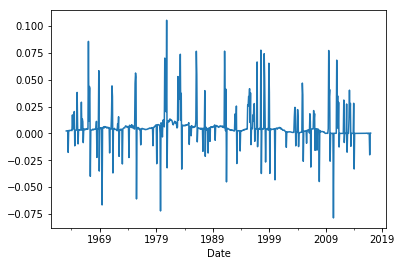

In [6]:
Data['MFQS']=Data.RF*Data.Wrf+Data.MKTUS*Data.Wmkt
Data.MFQS.plot()

* Why sometimes the strategy is totally flat?

* how does it compare with the market?

In [7]:
Data[['MKTUS','MFQS']].mean()*12

MKTUS    0.108621
MFQS     0.069005
dtype: float64

In [8]:
Data[['MKTUS','MFQS']].std()

MKTUS    0.044003
MFQS     0.016796
dtype: float64

Both average returns and volatility are lower

> Is it surprising?

* does it mean that someone that is more risk-averse than the average investor can benefit of investing in MFQS?


Looking at cumulative returns:



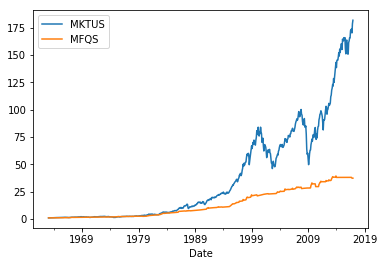

In [7]:
(Data[['MKTUS','MFQS']]+1).cumprod().plot()

Lets look at Sharpe Ratios. 

> How do we construct it?

> How do we annualize?

In [9]:
Data[['MKTUS','MFQS']].subtract(Data.RF,axis=0).mean()/Data[['MKTUS','MFQS']].std()*12**0.5

MKTUS    0.404668
MFQS     0.379282
dtype: float64

* Does this mean that MFQS is a bad idea?

* What does this mean for a mean-variance investor that can borrow and lend at the risk-free rate and must choose between investing in the risk-free and the market or the risk-free and MFQS?

* Is there a degree of risk aversion that would make the investor prefer MFQS over the Market?

* What if the investor could invest in all three assets? would he ever invest in MFQS?

### Volatility timing: A more sophisitcated timing strategy


* you guys learned in 411 that a mean-variance investor invest in the risky asset proportionally to the risk-return trade-off

$$W_t=\frac{\mu_t}{\gamma \sigma_t^2}$$


* Measuring variation in $\mu_t$, the expected excess return on the market is really hard 

   * there are theoretically motivated ways to do it, which we will discuss later, but they are not great empirically

* but measuring variaiton in volatility is much easier because volatility periods tend to cluster together

* lets download daily stock market data to show this visually

* We will download data not directly from the Wrds (Wharton Reseach Data Services ) server

* If you want you can get a login to get acess to it as well. All you need is to follow the steps

https://wrds-web.wharton.upenn.edu/wrds/?register=1

* Anyone during serious quant work needs a way to get a lot of data quickly. 

* Wrds has plenty of the basic sources

In [10]:
import datetime as dt
import wrds
import psycopg2 
from dateutil.relativedelta import *


# this connects with their server
conn=wrds.Connection()

# this gets the value-weighted market returns and date from the data base crsp.dsi
mkt_d = conn.raw_sql("""
                      select a.date, a.vwretd
                      from crsp.dsi as a
                      """) 
# gets the risk-free rate
rf_d = conn.raw_sql("""
                      select a.date, a.rf
                      from ff.factors_daily as a
                      """) 

#rf_d.to_csv('C:/Users/Alan Moreira/Dropbox/Public/Fin418/Data/rf_d.csv')
#mkt_d.to_csv('C:/Users/Alan Moreira/Dropbox/Public/Fin418/Data/mk_d.csv')

Enter your WRDS username [Alan Moreira]:moreira5
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [18]:
# alternatively simply import from dropbox or download from blackboard as usual

rf_d=pd.read_csv('https://www.dropbox.com/s/85n50ul6of2fsca/rf_d.csv?dl=1')
mk_d=pd.read_csv('https://www.dropbox.com/s/ns191hnic5gpx13/mk_d.csv?dl=1')

In [11]:
# this set the index
mkt_d=mkt_d.set_index(['date'])

mkt_d=mkt_d.set_index(pd.to_datetime(mkt_d.index),'date')

rf_d=rf_d.set_index(['date'])

rf_d=rf_d.set_index(pd.to_datetime(rf_d.index),'date')

# we merge

daily=mkt_d.merge(rf_d,how='left',left_index=True,right_index=True)
daily.tail()

,vwretd,rf
date,,
2018-12-24,-0.024171,0.0001
2018-12-26,0.046853,0.0001
2018-12-27,0.006828,0.0001
2018-12-28,0.000152,0.0001
2018-12-31,0.008324,0.0001


* We have daily data. How to construct monthly realized variance?

* note that the index is not longer a date

* it lost the date property because we grouped by transforming the date into a float

``mkt_d.index.month/12+mkt_d.index.year``

* As we simply got year and added the month divided by 12.

* it did the job, but it looses the date poperty which can be quite convenient

* here is the sophisticated way to do it: You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day.

In [12]:
from pandas.tseries.offsets import MonthEnd

In [21]:
daily.index

DatetimeIndex(['1925-12-31', '1926-01-02', '1926-01-04', '1926-01-05',
               '1926-01-06', '1926-01-07', '1926-01-08', '1926-01-09',
               '1926-01-11', '1926-01-12',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=24541, freq=None)

In [22]:
daily.index.year+daily.index.month/12

Float64Index([            1926.0, 1926.0833333333333, 1926.0833333333333,
              1926.0833333333333, 1926.0833333333333, 1926.0833333333333,
              1926.0833333333333, 1926.0833333333333, 1926.0833333333333,
              1926.0833333333333,
              ...
                          2019.0,             2019.0,             2019.0,
                          2019.0,             2019.0,             2019.0,
                          2019.0,             2019.0,             2019.0,
                          2019.0],
             dtype='float64', name='date', length=24541)

In [23]:
RV=daily.groupby(daily.index+MonthEnd(0)).var()

RV.tail()

,vwretd,rf
date,,
2018-08-31,0.000021,0.0
2018-09-30,0.000013,0.0
2018-10-31,0.000182,0.0
2018-11-30,0.000132,0.0
2018-12-31,0.000317,0.0


In [29]:
from pandas.tseries.offsets import MonthEnd

RV=daily.groupby(daily.index+MonthEnd(1)).var()

RV.tail()

,vwretd,rf
date,,
2018-09-30,0.000013,5.000000e-12
2018-10-31,0.000182,0.000000e+00
2018-11-30,0.000135,0.000000e+00
2018-12-31,0.000315,2.105263e-11
2019-01-31,NaN,NaN


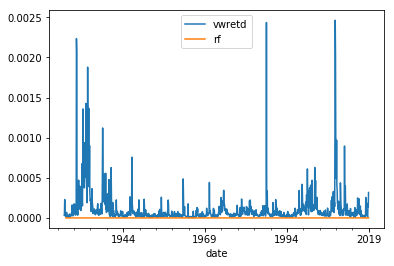

In [24]:
RV.plot()

And now you can do convenient stuff like this:

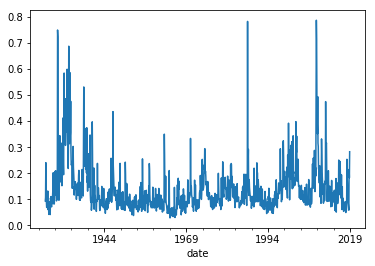

In [25]:
# looking in terms of standard deviations:

((RV.vwretd*252)**0.5).plot()

* we now need to do the trading strategy, motivated that Realized variance in month t is a good proxy for the expected variance next month (see plot above!)

* So we will for the following strategy with weight 

$$W_t=\frac{c}{RV_t}$$

on the market and weight $1-W_t$ on the risk-free rate.

* c controls how much risk the strategy takes overall, i.e., how levered it is on average.

* As we saw before all timing strategies involved some in and out of the market, but you also need to determine the average position. That is the role of c.

* Lets set the c such that the leverage is 4 when annualized standard deviation is 4%, so this means $RV=0.04^2/252$

* leverage is $W_t-1$

$$W_t-1=\frac{c}{RV_t}-1\leq 4$$

So  $c\leq 5 RV_t=5*0.04^2/252$

In [26]:
c=(5*(0.04**2)/252)
RV['W']=c/RV.vwretd

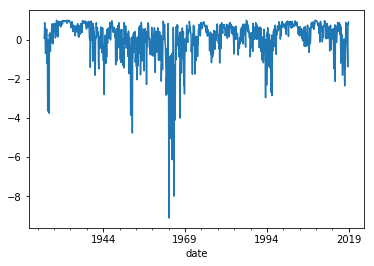

In [28]:
(1-RV.W).plot()

* Since the strategy will trade monthly, we now need to construct monthly returns

* we do that by cumulating daily returns within a month


In [30]:
Ret=(1+daily).groupby(daily.index+MonthEnd(0)).prod()-1
Ret.tail()

,vwretd,rf
date,,
2018-08-31,0.030352,0.001611
2018-09-30,0.000477,0.001521
2018-10-31,-0.073989,0.001842
2018-11-30,0.018697,0.001681
2018-12-31,-0.089711,0.001902


In [32]:
RV.tail()

,vwretd,rf,W
date,,,
2018-08-31,0.000021,0.0,1.545757
2018-09-30,0.000013,0.0,2.389341
2018-10-31,0.000182,0.0,0.174092
2018-11-30,0.000132,0.0,0.239809
2018-12-31,0.000317,0.0,0.100262


In [34]:
Ret.tail()

,vwretd,rf
date,,
2018-08-31,0.030352,0.001611
2018-09-30,0.000477,0.001521
2018-10-31,-0.073989,0.001842
2018-11-30,0.018697,0.001681
2018-12-31,-0.089711,0.001902


In [33]:
del RV['rf']

In [35]:
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
df.head()

,vwretd_x,W,vwretd_y,rf
date,,,,
1925-12-31,NaN,NaN,0.000000,0.0
1926-01-31,0.000035,0.919672,0.001126,0.0
1926-02-28,0.000045,0.708324,-0.033757,0.0
1926-03-31,0.000230,0.138235,-0.065741,0.0
1926-04-30,0.000054,0.586952,0.036812,0.0


In [36]:
# lets rename for clarity

df.columns=['RV','W','Mkt','Rf']
df.tail()

,RV,W,Mkt,Rf
date,,,,
2018-08-31,0.000021,1.545757,0.030352,0.001611
2018-09-30,0.000013,2.389341,0.000477,0.001521
2018-10-31,0.000182,0.174092,-0.073989,0.001842
2018-11-30,0.000132,0.239809,0.018697,0.001681
2018-12-31,0.000317,0.100262,-0.089711,0.001902


* Now to construct the strategy return recall that we use the relaized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1

* so we need to lag our weights, or lead the returns

* I will call it Volatility Managed Strategy

In [37]:
df['VMS']=df.W.shift(1)*df.Mkt+(1-df.W.shift(1))*df.Rf

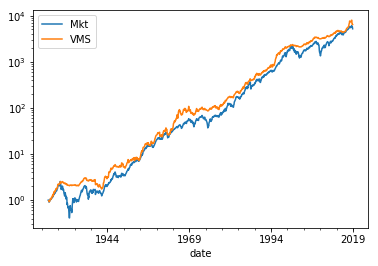

In [39]:
(df[['Mkt','VMS']]+1).cumprod().plot(logy=True)

In [46]:
df[['Mkt','VMS']].mean()

Mkt    0.009094
VMS    0.008413
dtype: float64

In [47]:
df[['Mkt','VMS']].std()

Mkt    0.053129
VMS    0.039261
dtype: float64

Sharpe ratio

In [40]:
(df[['Mkt','VMS']].subtract(df.Rf,axis=0).mean()/df[['Mkt','VMS']].std())*12**0.5

Mkt    0.414724
VMS    0.524339
dtype: float64

Tail risk

In [41]:
df[['Mkt','VMS']].quantile(q=0.01)

Mkt   -0.135659
VMS   -0.106184
Name: 0.01, dtype: float64

* What are other natural measures of risk to look at?

* Does any of this mean that VMS is a good/bad idea?

* What does this mean for a mean-variance investor that can borrow and lend at the risk-free rate and must choose between investing in the risk-free and the market or the risk-free and VMS?

* Is there a degree of risk aversion that would make the investor prefer Market over VMS?

* What if the investor could invest in all three assets? would he ever invest in the market on only on vms?

- This was just an example!

- There are a lot of timing strategies

- I like this one, becuase I (and Tyler Muir) came up with it. (https://www.google.com/url?q=https%3A%2F%2Fwww.dropbox.com%2Fs%2F022escr52x9oe51%2FVolPortfolios_published.pdf%3Fdl%3D0&sa=D&sntz=1&usg=AFQjCNGMECt2zp77lDfZRGJlkXQbGmqn1A)

- And it is also really easy to teach!



# Cross-sectional strategies

* So far we have looked at strategies that go in and out of a particular asset according to a signal. 

* We looked at past returns and past realized volatility.

* You can think these as strategies as "timing"  because they change how much risk they take over time.

* Now we will look at strategies that do not change their net exposure to the stock market over time, but changes which assets it buys.


## Value investing



One of the most popular quantitative investing strategies is broadly refered to as "value investing"

* It consists of tilting the portfolio towards stocks that have a low price relative to a proxy for it's fundamental value

* and tilt away form stocks with high price relative to fundamentals

* Broadly speaking: Buy cheap, sell expensive

* weights: 

$$W_t \propto \frac{F_t}{P_t}$$

* Where $F_t$ is some proxy for the firm fundamental value

* typically some accounting measure

* There is a vast number of proxys for fundamentals

  * Dividends
  * Book value
  * Earnings
  * Cash flow
  * Sales
  
* The strategy is the "cross-sectional" counterpart of market timing strategies that rely on Earnings to price ratio of aggregate market as a proxy for whether the market is expensive or cheap

* However, the evidence is that cross-sectional strategy is much more reliable, even if still quite risky

* The strategy is typically applied across stocks, but to warm things up, we will start with industry portfolios

* Industry portfolios are portfolios that hold market-cap weighted positions in all the firms in a specific industry

* Specifically, we will work with a classification where all firms are classified in 30 industries


Details

* need to tell which row return data starts/ends

* need to tell pandas how to interpret the date column

* divide by 100 to have the returns in percent

* Add the monthend shifter so the dates all are on an end of the month basis

#### Getting data on industry portfolios returns

In [3]:
url = "https://www.dropbox.com/s/3myt45gtdp5g5bq/IndustryPortfolios.csv?dl=1"
parser = lambda date: pd.to_datetime(date,format='%Y%m')
Data = pd.read_csv(url,index_col=0, \
                         parse_dates=True,date_parser=parser,skiprows=11,nrows=1128-12,na_values=-99.99)
Data=Data/100
Data.index=Data.index+pd.tseries.offsets.MonthEnd()
DataR=Data.copy()
DataR.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2019-02-28,-0.0338,0.0246,0.1020,0.0401,0.0428,0.0471,0.0550,0.0304,0.0392,0.0684,...,0.0331,0.0454,0.0711,0.0306,0.0418,0.0454,-0.0008,0.0465,0.0297,0.0027
2019-03-31,0.0387,0.0487,0.0645,-0.0009,-0.0570,0.0434,-0.0031,0.0060,-0.0148,-0.0776,...,0.0029,0.0309,0.0436,0.0141,-0.0036,-0.0152,0.0387,0.0384,-0.0233,0.0004
2019-04-30,0.0369,0.0656,-0.0356,0.0608,0.0148,0.0330,0.0489,-0.0306,0.0551,0.0678,...,0.0631,0.0629,0.0553,-0.0206,0.0466,0.0391,0.0493,0.0405,0.0707,0.0718
2019-05-31,-0.0306,-0.0396,-0.1029,-0.0845,-0.0985,-0.0395,-0.1102,-0.0345,-0.1291,-0.0239,...,-0.0305,-0.0588,-0.1178,-0.0919,-0.0941,-0.0594,-0.0701,-0.0204,-0.0544,-0.0704
2019-06-30,0.0458,0.0530,0.0103,0.0716,0.0786,0.0686,0.0904,0.0726,0.0344,0.0986,...,0.0503,0.0563,0.1119,0.0859,0.0681,0.0746,0.0715,0.0762,0.0624,0.0740


#### Getting our value signal

* Data set has two proxys for value

   * Sum of Book-equity across all stocks in portfolio divided by the sum of market equity across all stocks
   
   * The value weighted sum of Book equity to market equity
   
* They should be measuring pretty similar things

Details:

* We need to change the parser because now the data is in yearly

* need to adjsut which rows data start/data ends

In [83]:

parser = lambda date: pd.to_datetime(date,format='%Y')
Data = pd.read_csv(url,index_col=0, \
                         parse_dates=True,date_parser=parser,skiprows=4780,nrows=4874-4781,na_values=-99.99)
Data=Data
Data.index=Data.index+pd.tseries.offsets.MonthEnd()
DataBM=Data.copy()
DataBM.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2014-12-31,0.29,0.24,0.12,0.23,0.65,0.24,0.22,0.25,0.33,0.31,...,0.40,0.23,0.34,0.28,0.32,0.30,0.27,0.17,0.71,0.39
2015-12-31,0.27,0.17,0.09,0.23,0.68,0.22,0.19,0.21,0.29,0.28,...,0.34,0.24,0.27,0.19,0.24,0.32,0.23,0.15,0.69,0.37
2016-12-31,0.31,0.13,0.14,0.24,0.71,0.22,0.21,0.23,0.31,0.36,...,0.43,0.22,0.33,0.20,0.32,0.34,0.22,0.12,0.70,0.37
2017-12-31,0.28,0.14,0.12,0.19,0.72,0.20,0.23,0.23,0.29,0.39,...,0.38,0.21,0.29,0.19,0.28,0.31,0.21,0.18,0.63,0.33
2018-12-31,0.30,0.13,0.13,0.15,0.60,0.20,0.19,0.20,0.39,0.34,...,0.43,0.17,0.23,0.21,0.29,0.31,0.16,0.14,0.53,0.35


#### What does the value signal look like?

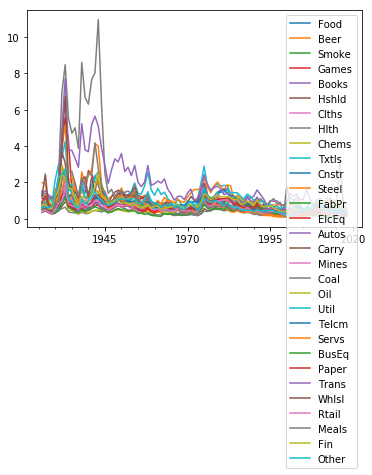

In [5]:
# lets look at what out value measure looks like
DataBM.plot()

* a lot of time-variation in it

* everything tends to be value at the same time (30's for example)

* strategy that we want to construct want to explore value across industries instead

* lets look at the difference between the most value and the least value industry

* will plot agaist the mean BM just for reference

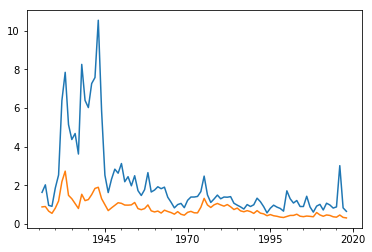

In [6]:
(DataBM.max(axis=1)-DataBM.min(axis=1)).plot()
(DataBM.mean(axis=1)).plot()

* Difference in BM about the same magnitude as average BM



### Long-short portfolios


* What is a long-short portfolio?

* It is a portfolio that is self-financed, for each dollar of stocks that it buys, it finances the position by shorting 1 dollar worth of stock in the other side

* So the returns of long-short portfolio are already excess returns

* We have worked with long-short portfolios before starting in Notebook 3

* but there our short side was always the risk-free rate

   * When we write $R^e_{mkt}=R_{mkt}-R_f$ we are constructing a long-short portfolio that goes long the market and short the risk-free asset
   
   * This portfolio as we discussed in Notebook 3 has zero cost, i.e., you don't need any capital, so it allow us to completely separate the time-value of money question from the risk premium question
   
   * The only difference is that now our short side will be a risky asset too, but the logic is the same
   
   
### Value investing across industries

* So now we will implement our value strategy by buying the inudstry portfolio with higher BM and short the industry portfolio with the lower BM

* We can start by simply constructing these two portfolios:
  * The portfolio that always holds the highest BM portfolio of the year before
  * The portfolio the always holds the lowest BM portfolio of the year before

### Quantitative investing is all about ranking

* [$\checkmark$] get returns for each asset

* [$\checkmark$] construct the signals for each asset

- [X]  rank the signals in each date

- [X]  Choose how many assets to pool together. Trade-off between signal strengh and diversification

     * If you only buy the highest signal asset, you loose diversification

In [7]:
DataBM.rank(axis=1,method='first').head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-01-31,9.0,30.0,17.0,23.0,29.0,1.0,13.0,11.0,12.0,28.0,...,20.0,16.0,4.0,22.0,27.0,25.0,2.0,5.0,10.0,8.0
1927-01-31,5.0,29.0,11.0,22.0,19.0,1.0,20.0,6.0,8.0,24.0,...,15.0,16.0,3.0,25.0,28.0,30.0,2.0,12.0,14.0,9.0
1928-01-31,8.0,22.0,15.0,24.0,9.0,2.0,29.0,1.0,6.0,28.0,...,21.0,18.0,4.0,23.0,30.0,16.0,5.0,13.0,12.0,14.0
1929-01-31,10.0,21.0,19.0,17.0,8.0,1.0,29.0,2.0,7.0,27.0,...,22.0,20.0,6.0,16.0,30.0,9.0,3.0,15.0,18.0,23.0
1930-01-31,7.0,21.0,26.0,22.0,11.0,2.0,18.0,4.0,5.0,30.0,...,12.0,29.0,3.0,15.0,25.0,23.0,8.0,17.0,24.0,28.0


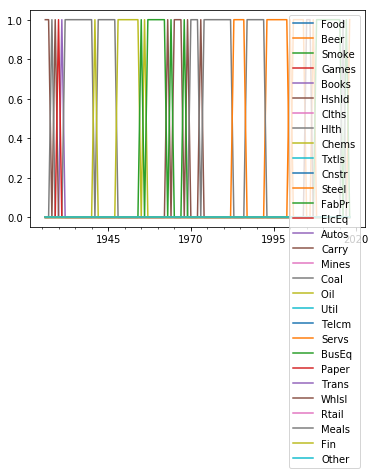

In [8]:
# The weigths for the short portfolio
((DataBM.rank(axis=1,method='first')==1)*1).plot()

In [9]:
1*(DataBM.rank(axis=1,method='first')==1).head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-01-31,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927-01-31,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1928-01-31,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1929-01-31,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1930-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


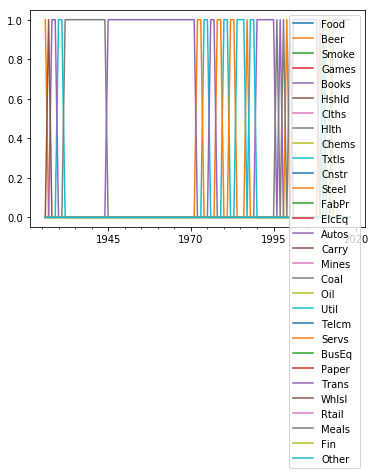

In [10]:
# the weights for the long portfolio
((DataBM.rank(axis=1,method='first')==30)*1).plot()

#### From signals to weights

* Here we choose to pool 3 assets toghether in the long and in the short side of our portfolios

In [11]:
WL=1*(DataBM.rank(axis=1,method='first')>27)
WL

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-01-31,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1927-01-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1928-01-31,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1929-01-31,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1930-01-31,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1931-01-31,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1932-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1933-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1934-01-31,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1935-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [12]:

WL=WL.divide(WL.sum(axis=1),axis=0)
WL.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-01-31,0,0.333333,0,0,0.333333,0,0,0,0,0.333333,...,0,0,0,0,0,0,0,0,0,0
1927-01-31,0,0.333333,0,0,0,0,0,0,0,0,...,0,0,0,0,0.333333,0.333333,0,0,0,0
1928-01-31,0,0,0,0,0,0,0.333333,0,0,0.333333,...,0,0,0,0,0.333333,0,0,0,0,0
1929-01-31,0,0,0,0,0,0,0.333333,0,0,0,...,0,0,0,0,0.333333,0,0,0,0,0
1930-01-31,0,0,0,0,0,0,0,0,0,0.333333,...,0,0.333333,0,0,0,0,0,0,0,0.333333


In [13]:

WS=1*(DataBM.rank(axis=1,method='first')<4)
WS=WS.divide(WS.sum(axis=1),axis=0)
W=WL.merge(WS,left_index=True,right_index=True,suffixes=['_L','_S'])
W.head()

,Food _L,Beer _L,Smoke_L,Games_L,Books_L,Hshld_L,Clths_L,Hlth _L,Chems_L,Txtls_L,...,Telcm_S,Servs_S,BusEq_S,Paper_S,Trans_S,Whlsl_S,Rtail_S,Meals_S,Fin _S,Other_S
1926-01-31,0,0.333333,0,0,0.333333,0,0,0,0,0.333333,...,0,0,0,0,0,0,0.333333,0,0,0
1927-01-31,0,0.333333,0,0,0,0,0,0,0,0,...,0,0,0.333333,0,0,0,0.333333,0,0,0
1928-01-31,0,0,0,0,0,0,0.333333,0,0,0.333333,...,0,0,0,0,0,0,0,0,0,0
1929-01-31,0,0,0,0,0,0,0.333333,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,0
1930-01-31,0,0,0,0,0,0,0,0,0,0.333333,...,0,0,0.333333,0,0,0,0,0,0,0


* We have the weights!

* We just need to merge with the return data

* remind that we need to lag the BM data by a year.

* so we use the BM data of year t, do decide which portfolio to hold during all months of year t+1

In [19]:
# this assigns the year t BM to year t+1
W.shift(1).head()

,Food _L,Beer _L,Smoke_L,Games_L,Books_L,Hshld_L,Clths_L,Hlth _L,Chems_L,Txtls_L,...,Telcm_S,Servs_S,BusEq_S,Paper_S,Trans_S,Whlsl_S,Rtail_S,Meals_S,Fin _S,Other_S
1926-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-01-31,0,0.333333,0,0,0.333333,0,0,0,0,0.333333,...,0,0,0,0,0,0,0.333333,0,0,0
1928-01-31,0,0.333333,0,0,0,0,0,0,0,0,...,0,0,0.333333,0,0,0,0.333333,0,0,0
1929-01-31,0,0,0,0,0,0,0.333333,0,0,0.333333,...,0,0,0,0,0,0,0,0,0,0
1930-01-31,0,0,0,0,0,0,0.333333,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,0


### Portfolio formation tradeoffs


* Why no simply focus on the highest value industries?

* Why construct portfolios of multiple industries?

* Imagine that we are working with individual stocks instead of industry portfolios for a second:

i. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.

ii. So if you have to trade-off strenght of the signal against benefits of diversification



#### Merging back with the returns series

In [14]:
# we want to merge on year, so we need to construct the year variable in the two data sets
Temp=DataR.copy()
Temp['date']=Temp.index
Temp['year']=Temp.index.year
W['year']=W.index.year

In [15]:
Temp.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other,date,year
1926-07-31,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520,1926-07-31,1926
1926-08-31,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676,1926-08-31,1926
1926-09-30,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386,1926-09-30,1926
1926-10-31,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849,1926-10-31,1926
1926-11-30,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400,1926-11-30,1926


In [16]:
W.tail()

,Food _L,Beer _L,Smoke_L,Games_L,Books_L,Hshld_L,Clths_L,Hlth _L,Chems_L,Txtls_L,...,Servs_S,BusEq_S,Paper_S,Trans_S,Whlsl_S,Rtail_S,Meals_S,Fin _S,Other_S,year
2014-01-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,2014
2015-01-31,0,0,0,0,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,2015
2016-01-31,0,0,0,0,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,2016
2017-01-31,0,0,0,0,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,2017
2018-01-31,0,0,0,0,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0.333333,0,0,2018


In [17]:
Data=Temp.merge(W.shift(1),how='left', on='year')
del Temp
Data=Data.set_index(['date'])
Data.head()


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm_S,Servs_S,BusEq_S,Paper_S,Trans_S,Whlsl_S,Rtail_S,Meals_S,Fin _S,Other_S
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0,0,0,0,0,0,0.333333,0,0,0
1926-08-31,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0,0,0,0,0,0,0.333333,0,0,0
1926-09-30,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0,0,0,0,0,0,0.333333,0,0,0
1926-10-31,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,0,0,0,0,0,0,0.333333,0,0,0
1926-11-30,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0,0,0,0,0,0,0.333333,0,0,0


In [23]:
Data.shape

(1098, 92)

In [18]:
#Drop rows for which you do not have signal data
Data=Data.dropna(axis=0)

In [24]:
# inspect to see if your data set looks like you expect
Data.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other', 'Food _L',
       'Beer _L', 'Smoke_L', 'Games_L', 'Books_L', 'Hshld_L', 'Clths_L',
       'Hlth _L', 'Chems_L', 'Txtls_L', 'Cnstr_L', 'Steel_L', 'FabPr_L',
       'ElcEq_L', 'Autos_L', 'Carry_L', 'Mines_L', 'Coal _L', 'Oil  _L',
       'Util _L', 'Telcm_L', 'Servs_L', 'BusEq_L', 'Paper_L', 'Trans_L',
       'Whlsl_L', 'Rtail_L', 'Meals_L', 'Fin  _L', 'Other_L', 'Food _S',
       'Beer _S', 'Smoke_S', 'Games_S', 'Books_S', 'Hshld_S', 'Clths_S',
       'Hlth _S', 'Chems_S', 'Txtls_S', 'Cnstr_S', 'Steel_S', 'FabPr_S',
       'ElcEq_S', 'Autos_S', 'Carry_S', 'Mines_S', 'Coal _S', 'Oil  _S',
       'Util _S', 'Telcm_S', 'Servs_S', 'BusEq_S', 'Paper_S', 'Trans_S',
       'Whlsl_S', 'Rtail_S', 'Meal

#### Calculate the portfolio return

$$\sum_i^I W_{it} R_{it}$$

Where the weights must add up to 1.

In the code below we have

``R=x[0:30]
W=x[30:60]/x[30:60].sum()``



In [21]:
del Data['year']

In [22]:

Data['R_L']=(Data.iloc[:,0:30]*Data.iloc[:,30:60].values).sum(axis=1)
Data['R_S']=(Data.iloc[:,0:30]*Data.iloc[:,60:90].values).sum(axis=1)
Data[['R_L','R_S']].head()

,R_L,R_S
date,,
1926-07-31,0.020567,0.009233
1926-08-31,0.150600,-0.007433
1926-09-30,0.017800,0.001400
1926-10-31,0.023867,-0.042033
1926-11-30,0.015333,0.036867


* How do we know that this is doing what we want?

* We do it manually for one

In [41]:
Data.iloc[2,30:60]

Food _L           0
Beer _L    0.333333
Smoke_L           0
Games_L           0
Books_L    0.333333
Hshld_L           0
Clths_L           0
Hlth _L           0
Chems_L           0
Txtls_L    0.333333
Cnstr_L           0
Steel_L           0
FabPr_L           0
ElcEq_L           0
Autos_L           0
Carry_L           0
Mines_L           0
Coal _L           0
Oil  _L           0
Util _L           0
Telcm_L           0
Servs_L           0
BusEq_L           0
Paper_L           0
Trans_L           0
Whlsl_L           0
Rtail_L           0
Meals_L           0
Fin  _L           0
Other_L           0
Name: 1926-09-30 00:00:00, dtype: object

In [42]:
Data.iloc[0,[1,4,9]]

Beer    -0.0519
Books    0.1097
Txtls    0.0039
Name: 1926-07-31 00:00:00, dtype: object

In [31]:
Data.iloc[1,90]

0.15059999999999998

* Now that this is checked we can look at the strategy more carefully



In [32]:
Data.loc[:,['R_L','R_S']].mean()

R_L    0.011079
R_S    0.010057
dtype: float64

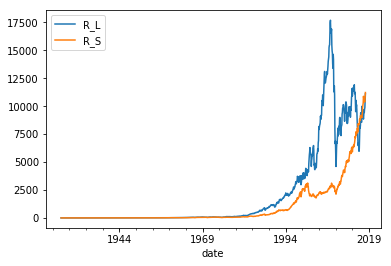

In [33]:
(Data[['R_L','R_S']]+1).cumprod().plot()

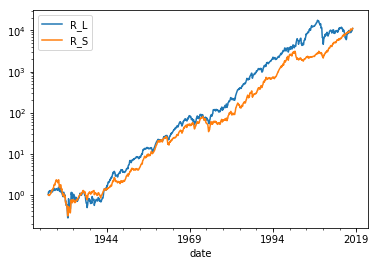

In [34]:
(Data[['R_L','R_S']]+1).cumprod().plot(logy=True)

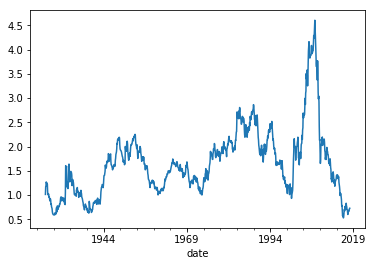

In [35]:
Data['R_HmL']=Data['R_L'].subtract(Data['R_S'])

(1+Data.R_HmL).cumprod().plot()

# The scalable approach to construct quant portfolios

* So far we followed what I call the "excel" approach

* The overall structure of the data set is very similar to how we organize it in excel. 

* This means that it is quite limited as well. It is ok for  a few assets, but it quickly becomes hard to work with once your portfolios take position in all stocks (30 vs 5000!)

* So far we had in the row the dates and in the columns the different assets

* We then had the different signals about the asset in different dataframes, or simply glued then together, but we had to manually know in which column was which information

* Once you have stocks that disappear and new ones that come up, you need a column for each stock that was ever traded. This can easily be 50000 columns...so it get unmanageable


* The serious/scalable way of doing this is to put each variable in  a column and use another column to carry the indentity of the observation. 

* this way you always have one column for the date, one for the indentiy, and one for the variable. If you have more than one variable, then it only adds one more column

* Of course, now you have lots of rows!

* but if a stock did not trade in a particular date, the row simply does not exist in the data set. So overally it is much more compact

>We start by unstacking our data set to put in the row format

In [43]:

DataR.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-31,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08-31,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09-30,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10-31,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11-30,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [48]:
DataUR=DataR.unstack()
DataUR=pd.DataFrame(DataUR)
DataUR

0
Food  1926-07-31  0.0056
      1926-08-31  0.0259
      1926-09-30  0.0116
      1926-10-31 -0.0306
      1926-11-30  0.0635
      1926-12-31 -0.0051
      1927-01-31 -0.0084
      1927-02-28  0.0442
      1927-03-31  0.0209
      1927-04-30  0.0272
      1927-05-31  0.0613
      1927-06-30 -0.0222
      1927-07-31  0.0504
      1927-08-31  0.0233
      1927-09-30  0.0604
      1927-10-31 -0.0246
      1927-11-30  0.0717
      1927-12-31  0.0353
      1928-01-31  0.0254
      1928-02-29 -0.0296
      1928-03-31  0.0511
      1928-04-30  0.0269
      1928-05-31  0.0160
      1928-06-30 -0.0393
      1928-07-31  0.0106
      1928-08-31  0.0785
      1928-09-30  0.0174
      1928-10-31 -0.0047
      1928-11-30  0.0662
      1928-12-31  0.0056
...                  ...
Other 2017-01-31 -0.0079
      2017-02-28  0.0371
      2017-03-31 -0.0178
      2017-04-30 -0.0095
      2017-05-31 -0.0068
      2017-06-30  0.0137
      2017-07-31  0.0148
      2017-08-31  0.0160
      2017-09-30  0.0108
      2017-10-31 -0.0112
      2017-11-30  0.0171
      2017-12-31  0.0121
      2018-01-31  0.0551
      2018-02-28 -0.0444
      2018-03-31 -0.0340
      2018-04-30 -0.0190
      2018-05-31 -0.0038
      2018-06-30 -0.0204
      2018-07-31  0.0605
      2018-08-31  0.0303
      2018-09-30  0.0117
      2018-10-31 -0.0599
      2018-11-30  0.0349
      2018-12-31 -0.0692
      2019-01-31  0.0480
      2019-02-28  0.0027
      2019-03-31  0.0004
      2019-04-30  0.0718
      2019-05-31 -0.0704
      2019-06-30  0.0740

[33480 rows x 1 columns]

In [49]:
DataUBM=DataBM.unstack()
DataUBM=pd.DataFrame(DataUBM)
DataUBM.tail()

0
Other 2014-01-31  0.39
      2015-01-31  0.37
      2016-01-31  0.37
      2017-01-31  0.33
      2018-01-31  0.35

I am not great working with Multi-index so I will simply have three columns

In [50]:
DataUBM=DataUBM.reset_index()
DataUR=DataUR.reset_index()
DataUBM.head()

,level_0,level_1,0
0,Food,1926-01-31,0.71
1,Food,1927-01-31,0.57
2,Food,1928-01-31,0.46
3,Food,1929-01-31,0.38
4,Food,1930-01-31,0.48


In [52]:
DataUR.head()

,level_0,level_1,0
0,Food,1926-07-31,0.0056
1,Food,1926-08-31,0.0259
2,Food,1926-09-30,0.0116
3,Food,1926-10-31,-0.0306
4,Food,1926-11-30,0.0635


* We will now prepare the BM data to merge.

* recall that it is yearly, with the data recorded in the first month of each year

* Instead of merging by year like we did before (it would work too), I will do something slight different

* I will use the resample method in pandas to switch from yearly to monthly frequency

  * https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

* Obviously pandas cannot create monthly data when it does not exist, so we have to tell it what is the rule to follow

* In this case we will tell Pandas to forward fill, that is when the go to monthly, there will be no data for the month of feburary, then by foward filling, pandas will simply the last observation available and fill for the month of february


* note that this accomplishes exactly as we want as all the month in say the year 2018 will get assigned the BM value of the month of january 2018

In [58]:
DataUBM.set_index('level_1').groupby('level_0', group_keys=False).resample('M').ffill().reset_index()

,level_1,level_0,0
0,1926-01-31,Autos,0.62
1,1926-02-28,Autos,0.62
2,1926-03-31,Autos,0.62
3,1926-04-30,Autos,0.62
4,1926-05-31,Autos,0.62
5,1926-06-30,Autos,0.62
6,1926-07-31,Autos,0.62
7,1926-08-31,Autos,0.62
8,1926-09-30,Autos,0.62
9,1926-10-31,Autos,0.62


In [63]:

DataUBM=DataUBM.set_index('level_1').groupby('level_0', group_keys=False).resample('M').ffill().reset_index()
DataUBM.head()

,level_1,level_0,0
0,1926-01-31,Autos,0.62
1,1926-02-28,Autos,0.62
2,1926-03-31,Autos,0.62
3,1926-04-30,Autos,0.62
4,1926-05-31,Autos,0.62


* We now can merge

* note that we merge in both the industry (level_0) and the date (level_1)

* this simply means that he will match the returns of a particular month for a particular industry and put it together with the bm for this same industry in this same date

In [64]:
DataU=DataUR.merge(DataUBM,on=['level_0','level_1'],suffixes=['r','bm'])
DataU.head()

,level_0,level_1,0r,0bm
0,Food,1926-07-31,0.0056,0.71
1,Food,1926-08-31,0.0259,0.71
2,Food,1926-09-30,0.0116,0.71
3,Food,1926-10-31,-0.0306,0.71
4,Food,1926-11-30,0.0635,0.71


In [65]:
#just rename so we avoid confusion
DataU.rename(columns={'level_0':'ind','level_1':'date','0r':'r','0bm':'bm'},inplace=True)
DataU.head()

,ind,date,r,bm
0,Food,1926-07-31,0.0056,0.71
1,Food,1926-08-31,0.0259,0.71
2,Food,1926-09-30,0.0116,0.71
3,Food,1926-10-31,-0.0306,0.71
4,Food,1926-11-30,0.0635,0.71


* We will now lag our Book-to-Market signal by 18 months.

Details:

* This is just to make it consistent with how the value sort is typically done


    * Value portfolios are typically rebalanced every july using Boom-to-market data from the year before
    
    * this means that from July/2006 to June/2007 you use Book to market data from December/2005
    
    * Because the fay we construct the data, the Bm data will be the same from Jan/2005 to December/2005
    
    * So if we lag the data 18 months, the Janruary/2005 bm gets matched with July/2006 and December/2005 get match to june/2007
    
    
> What is important is that we lag at least 12 months, to make sure that the BM data was available at the day of portfolio formation!    

In [62]:
DataU.head()

,ind,date,r,bm,bm_l18
0,Food,1927-01-31,-0.0084,0.57,NaN
1,Food,1928-01-31,0.0254,0.46,NaN
2,Food,1929-01-31,0.0349,0.38,NaN
3,Food,1930-01-31,0.0505,0.48,NaN
4,Food,1931-01-31,0.0553,0.63,NaN


In [67]:
DataU['bm_l18']=DataU.groupby(['ind']).bm.shift(18)
DataU.head()

,ind,date,r,bm,bm_l18
0,Food,1926-07-31,0.0056,0.71,NaN
1,Food,1926-08-31,0.0259,0.71,NaN
2,Food,1926-09-30,0.0116,0.71,NaN
3,Food,1926-10-31,-0.0306,0.71,NaN
4,Food,1926-11-30,0.0635,0.71,NaN


We now do both the ranking and grouping in one single command

* Here we use qdcut to split the portfolios by book to market in 5 quantiles

* the key here is to use the groupby operation to group things by date and do the quantile grouping in each date

* Pandas is for each date ranking the portfolios and giving then labels 1 to 5 according to the value of the signal

* Because pandas ranking starts at 0, we add one so our portfolios are 1 to 5



In [79]:
ngroups=5
DataU['bm_group']=DataU.groupby(['date'])['bm_l18'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
DataU['bm_group']=DataU['bm_group']+1

In [77]:
DataU.tail()

,ind,date,r,bm,bm_l18,bm_group
32965,Other,2017-09-30,0.0108,0.33,0.37,2.0
32966,Other,2017-10-31,-0.0112,0.33,0.37,2.0
32967,Other,2017-11-30,0.0171,0.33,0.37,2.0
32968,Other,2017-12-31,0.0121,0.33,0.37,2.0
32969,Other,2018-01-31,0.0551,0.35,0.37,2.0


We now have for each asset which portfolio it belongs to

Becasue we are doing equal-weighted portfolios all we need to do to compute the portfolio return is, for a given portfolio and for a given date, to compute the average return across industries :

In [80]:
port = DataU.groupby(['date','bm_group'])[['r','bm_l18']].mean()
port.head()

r    bm_l18
date       bm_group                    
1928-01-31 1.0       0.000143  0.505714
           2.0       0.004440  0.710000
           3.0       0.022400  0.806667
           4.0      -0.008750  0.985000
           5.0       0.000133  1.475000

We can now unstack so we can play with our portfolios the way we are used to

In [81]:
port_r=port.r.unstack(level=-1)
port_r.head()

bm_group,1.0,2.0,3.0,4.0,5.0
date,,,,,
1928-01-31,0.000143,0.00444,0.022400,-0.008750,0.000133
1928-02-29,-0.000800,-0.01816,-0.023900,-0.020017,-0.041067
1928-03-31,0.122857,0.09446,0.037283,0.068267,0.080867
1928-04-30,0.017229,0.04920,0.059833,0.022050,0.036067
1928-05-31,0.037357,0.03066,-0.010133,0.035050,0.049683


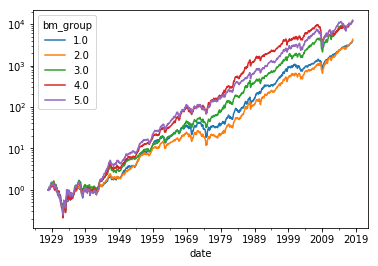

In [82]:
(port_r+1).cumprod().plot(logy=True)

#### Summing up

Here are all steps with explanations of what each of them does

In [88]:
# stack the data set up 
DataUR=DataR.unstack()
DataUR=pd.DataFrame(DataUR)

DataUBM=DataBM.unstack()
DataUBM=pd.DataFrame(DataUBM)

# make date and industry stndard columns instead of indexes(easier to work with)
DataUR=DataUR.reset_index()
DataUBM=DataUBM.reset_index()

# change the frequecny of signal to monthly (this only applies because our signal was at a different frequency
# of our returns )
DataUBM=DataUBM.set_index('level_1').groupby('level_0', group_keys=False) \
    .resample('M').ffill().reset_index()
    
# merge data sets together
DataU=DataUR.merge(DataUBM,on=['level_0','level_1'],suffixes=['r','bm'])
# rename variables
DataU.rename(columns={'level_0':'ind','level_1':'date','0r':'r','0bm':'bm'},inplace=True)

# lag signal. Here we are lagging by 18 months
# what is important is to lag enought so that you never trade on forward looking information
DataU['bm_l18']=DataU.groupby(['ind']).bm.shift(18)

# create the portfolio indenties, by ranking and labeling the industries according to the relative rank in agiven date
# this is the most common step in quanttitative strategies
DataU['bm_group']=DataU.groupby(['date'])['bm_l18'].transform(lambda x: pd.qcut(x, 5, labels=False,duplicates='drop'))
DataU['bm_group']=DataU['bm_group']+1
# compute the Equal-weighted returns
DataU


,ind,date,r,bm,bm_l18,bm_group
0,Food,1926-12-31,-0.0051,0.71,NaN,NaN
1,Food,1927-01-31,-0.0084,0.71,NaN,NaN
2,Food,1927-02-28,0.0442,0.71,NaN,NaN
3,Food,1927-03-31,0.0209,0.71,NaN,NaN
4,Food,1927-04-30,0.0272,0.71,NaN,NaN
5,Food,1927-05-31,0.0613,0.71,NaN,NaN
6,Food,1927-06-30,-0.0222,0.71,NaN,NaN
7,Food,1927-07-31,0.0504,0.71,NaN,NaN
8,Food,1927-08-31,0.0233,0.71,NaN,NaN
9,Food,1927-09-30,0.0604,0.71,NaN,NaN


In [87]:
port_r

bm_group,1.0,2.0,3.0,4.0,5.0
date,,,,,
1928-06-30,-0.042257,-0.063780,-0.049783,-0.048067,-0.071767
1928-07-31,0.019043,0.009520,-0.004450,0.004617,0.001450
1928-08-31,0.092000,0.098640,0.056617,0.073867,0.064267
1928-09-30,0.037443,0.024900,0.012283,0.025533,0.013983
1928-10-31,0.030214,0.004400,0.006967,0.000250,0.065150
1928-11-30,0.124757,0.075660,0.128383,0.098983,0.086683
1928-12-31,0.010886,-0.017880,-0.019300,0.008917,-0.016617
1929-01-31,0.038643,0.078540,0.012050,0.086050,0.028833
1929-02-28,-0.017257,-0.014320,0.001783,0.027917,0.001400


### LEcture 9 9/30

### Value-weighted portfolios

* We have so far focused on Equal-weighted portfolios

* This is fine in this case as the industries themselves are Value-weighted

* When working with stocks, if you EW you most load on tiny stocks

* So whatever pattern you find is unlikely to be tradable, because small stocks tend to be very illiquid

* Even if tradable, the scale of the strategy will be quite limited as prices will move quickly up as you start to buy

* So lets construct Market-Cap weighted portfolio

* these portfolio buy in proportion to the market cap of the firm, so small stocks will only get a small allocation to it

* this makes this portfolios much easier to trade

* doing this is very easy, essentially a weighted average of returns

* Here is more involved because we need to construct the market cap measure and merge back to our original data set before doing the final step


In [ ]:
# import number of firms in each portfolio
url = "https://www.dropbox.com/s/3myt45gtdp5g5bq/IndustryPortfolios.csv?dl=1"
parser = lambda date: pd.to_datetime(date,format='%Y%m')
Data= pd.read_csv(url,index_col=0, \
                         parse_dates=True,date_parser=parser,skiprows=2444,nrows=3560,na_values=-99.99)
Data=Data/100
Data.index=Data.index+pd.tseries.offsets.MonthEnd()
Nfirms=Data.copy()
# import average market cap
Data= pd.read_csv(url,index_col=0, \
                         parse_dates=True,date_parser=parser,skiprows=3564,nrows=4680,na_values=-99.99)
Data=Data/100
Data.index=Data.index+pd.tseries.offsets.MonthEnd()
AvgSize=Data.copy()
# compute total market cap of portfolio
Mktcap=AvgSize*Nfirms.values

# merge with our data
Mktcap=Mktcap.unstack()
Mktcap=pd.DataFrame(Mktcap)
Mktcap=Mktcap.reset_index()
# rename variables
Mktcap.rename(columns={'level_0':'ind','level_1':'date','0':'mktcap'},inplace=True)
# merge data sets together
DataU=DataU.merge(Mktcap,on=['ind','date'])




* It is important when constructing any weights that the weights that you are using are a function only of variable known before the time of the trade.

* Form Market-Cap weighted portfolio this means lagging the return by a period.

* If you didn't lag what would be doing? What bias would that introduce?



In [ ]:
DataU['mktcap_l1']=DataU.groupby('ind')['mktcap'].shift(1)

> Why did we "groupby ind" before lagging?

In [ ]:
def wavg(group):
    d = group['r']
    w = group['mktcap_l1']
    try:
            return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

port = DataU.groupby(['date','bm_group']).apply(wavg)

port_r=port.r.unstack(level=-1)

### Signal-Weighted portfolios


* it is practice in the industry to use the signals to weight the portfolios

* This is typically done as follows:

  * Lets say that the signal is BM, then weights in the long side are:
  
  $$ W_i^L=\frac{max(0,BM_i-\hat BM)}{\sum_i^Imax(0,BM_i-\hat BM)}$$
  
  * and in the short side

  $$ W_i^S=\frac{max(0,\hat BM-BM_i)}{\sum_i^I max(0,\hat BM-BM_i)}$$
  
  
 * With the final strategy weights
 
 $$W^L-W^S$$
  
  
  > Is there any single stock in both portfolios?
  
  * The issue with these portfolio is that they tend to put a lot of weight on small hard to trade stocks


### Returns based sorts: Momentum portfolios

# Momentum


Here is how Daniel and Moskowitz construct their portfolios


>To form the momentum portfolios, we first rank stocks based on their cumulative returns
from 12 months before to one month before the formation date (i.e., the t-12 to t-2-month
returns), where, consistent with the literature (Jegadeesh and Titman, 1993, Asness, 1994,
Fama and French, 1996), we use a one month gap between the end of the ranking period and
the start of the holding period to avoid the short-term reversals documented by Jegadeesh
(1990) and Lehmann (1990). In particular we will focus on 10% and 90% quantiles of the signal distribution and will construct portfolios of all stocks that are in the bottom and top quantiles



we now have our portfolio composition! 

if equal-weight we just need to invest $1/N_{i,t}$ in any stocks in quantile i.

where $1/N_{i,t}$  is the number of stocks in quantile i 



In [94]:
DataUR=DataR.unstack()
DataUR=pd.DataFrame(DataUR)
DataUR=DataUR.reset_index()
DataUR.rename(columns={'level_0':'ind','level_1':'date',0:'R'},inplace=True)
DataUR=DataUR.set_index(['date'])
DataUR.head()

,ind,R
date,,
1926-07-31,Food,0.0056
1926-08-31,Food,0.0259
1926-09-30,Food,0.0116
1926-10-31,Food,-0.0306
1926-11-30,Food,0.0635


Construct the signal

Step 1: Construct 10 montsh cumulative returrn



In [105]:
DataUR['logret']=np.log(DataUR['R']+1)
temp=DataUR.groupby('ind')[['logret']].rolling(window=10).sum()
temp =temp.reset_index()
temp['cumret']=np.exp(temp['logret'])-1# transform back in geometric  returns
temp.head()

,ind,date,logret,cumret
0,Autos,1926-07-31,NaN,NaN
1,Autos,1926-08-31,NaN,NaN
2,Autos,1926-09-30,NaN,NaN
3,Autos,1926-10-31,NaN,NaN
4,Autos,1926-11-30,NaN,NaN


In [106]:
temp = pd.merge(DataUR.reset_index(), temp[['ind','date','cumret']], how='left', on=['ind','date'])
# merge the 12 month return signal back to the original database
temp['mom']=temp.groupby('ind')['cumret'].shift(2)
temp.tail()

,date,ind,R,logret,cumret,mom
33475,2019-02-28,Other,0.0027,0.002696,0.026556,-0.074244
33476,2019-03-31,Other,0.0004,0.000400,0.030884,0.004339
33477,2019-04-30,Other,0.0718,0.069339,0.127911,0.026556
33478,2019-05-31,Other,-0.0704,-0.073001,-0.011310,0.030884
33479,2019-06-30,Other,0.0740,0.071390,0.030625,0.127911


In [113]:

mom=temp.sort_values(['date','ind']) # sort by date and firm identifier 

mom=mom.dropna(subset=['mom'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing


mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))

# create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
#in a given month 



# transform in string the group names
mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)
mom.head(24)

,date,ind,R,logret,cumret,mom,mom_group
15635,1927-06-30,Autos,-0.0337,-0.034281,0.227100,0.459686,m9
1127,1927-06-30,Beer,0.1005,0.095765,0.282525,0.257460,m7
4475,1927-06-30,Books,0.1254,0.118139,0.308501,0.376322,m9
24563,1927-06-30,BusEq,0.0273,0.026934,0.321220,0.303736,m7
16751,1927-06-30,Carry,-0.0390,-0.039781,0.159874,0.116462,m3
8939,1927-06-30,Chems,-0.0172,-0.017350,0.362572,0.523094,m9
6707,1927-06-30,Clths,0.0117,0.011632,0.160436,0.169177,m5
11171,1927-06-30,Cnstr,-0.0469,-0.048035,0.078312,0.124825,m3
18983,1927-06-30,Coal,-0.0335,-0.034074,0.125330,0.155456,m4
14519,1927-06-30,ElcEq,0.0347,0.034112,0.185258,0.114993,m2


In [116]:
mom=mom[['date','ind','R','mom_group']]
mom=mom.sort_values(['ind','date']) # resort 

# To form equal weighted portfolios is enotuh
port_vwret = mom.groupby(['date','mom_group']).mean()
port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
port_vwret.head(20)

R
date       mom_group          
1927-06-30 m0        -0.006267
           m1        -0.022933
           m2        -0.016567
           m3        -0.040533
           m4        -0.018333
           m5        -0.010067
           m6         0.002300
           m7         0.034967
           m8        -0.036767
           m9         0.024833
1927-07-31 m0         0.086800
           m1         0.060200
           m2         0.072800
           m3         0.073967
           m4         0.058733
           m5         0.069200
           m6         0.058800
           m7         0.106800
           m8         0.042333
           m9         0.088900

In [117]:
port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
# row the different dates
port_vwret.head()

R                                                    \
mom_group         m0        m1        m2        m3        m4        m5   
date                                                                     
1927-06-30 -0.006267 -0.022933 -0.016567 -0.040533 -0.018333 -0.010067   
1927-07-31  0.086800  0.060200  0.072800  0.073967  0.058733  0.069200   
1927-08-31  0.010267  0.029300  0.046933  0.018833  0.012800  0.032733   
1927-09-30  0.044267  0.017533  0.064600  0.041133  0.061433  0.046600   
1927-10-31 -0.077500 -0.044967 -0.020967  0.010733 -0.036933  0.016600   

                                                    
mom_group         m6        m7        m8        m9  
date                                                
1927-06-30  0.002300  0.034967 -0.036767  0.024833  
1927-07-31  0.058800  0.106800  0.042333  0.088900  
1927-08-31  0.027167 -0.007033  0.052567  0.021333  
1927-09-30  0.051467  0.075067  0.022100  0.051467  
1927-10-31 -0.008367 -0.050300 -0.000033 -0.067433

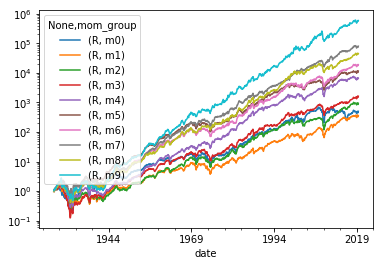

In [121]:
(port_vwret+1).cumprod().plot(logy=True)

> How to costruct value-weighted portfolios?
> What are the steps? Where would you change the code? How?

### Summing up

In [26]:
ngroups=5
DataUR=DataR.unstack()
DataUR=pd.DataFrame(DataUR)
DataUR=DataUR.reset_index()
DataUR.rename(columns={'level_0':'ind','level_1':'date',0:'R'},inplace=True)
DataUR=DataUR.set_index(['date'])


DataUR['logret']=np.log(DataUR['R']+1)
temp=DataUR.groupby('ind')[['logret']].rolling(window=12).sum()
temp =temp.reset_index()
temp['cumret']=np.exp(temp['logret'])-1# transform back in geometric  returns


temp = pd.merge(DataUR.reset_index(), temp[['ind','date','cumret']], how='left', on=['ind','date'])
# merge the 12 month return signal back to the original database
temp['mom']=temp.groupby('ind')['cumret'].shift(2)


mom=temp.sort_values(['date','ind']) # sort by date and firm identifier 
mom=mom.dropna(subset=['mom'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
# create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
#in a given month 
# transform in string the group names
mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)


mom=mom[['date','ind','R','mom_group']]
mom=mom.sort_values(['ind','date']) # resort 

# To form equal weighted portfolios is enough to take means!
port_vwret = mom.groupby(['date','mom_group']).mean()
# row the different dates
port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
port_vwret=port_vwret.unstack(level=-1) 
port_vwret.head(10)

R                                        
mom_group         m0        m1        m2        m3        m4
date                                                        
1927-07-31  0.073500  0.071583  0.051317  0.089067  0.073800
1927-08-31  0.025783  0.026650  0.012150  0.040983  0.016883
1927-09-30  0.036067  0.048817  0.058367  0.055733  0.038850
1927-10-31 -0.061233 -0.034233  0.003383 -0.014883 -0.032617
1927-11-30  0.050583  0.075167  0.091617  0.070117  0.075167
1927-12-31  0.022217  0.038917  0.029133  0.014050  0.040467
1928-01-31 -0.010317  0.001117  0.027050 -0.002433  0.002233
1928-02-29 -0.020467 -0.020400 -0.029467 -0.015017 -0.015700
1928-03-31  0.070017  0.040983  0.063067  0.094517  0.139883
1928-04-30  0.042233  0.020367  0.008450  0.044250  0.063750

### The General Recipe

1. Decide on a trading signal (last 12 month return, Book/Market,beta,...)

2. Calculate the trading signal for each stock

3. Group the stocks according to the strengh of the trading signal
    
    - must choose the number of groups, i.e. number of portfolios
    
    - If you choose very few (lets say two), you get the benefit of diversification, but the cost of having only a small spread on the strenght of the trading signal across portfolios
    
    - IF you choose a lot of groups (say 100), you benefit of having a lot of having a large spread in the trading signal
        
        - Portfolio 100 only have really strong stocks
        - Portfolio 1 only really weak stocks
        
    - But there are jsut very few stocks in each portfolio, so you will have a very volatile portfolio    
    
    
4. You have to decide how to weight the stocks within each bin

     - If you value-weight you make more likely that this portfolio can be traded at low cost
     
     - Equal-weighting can sometimes provide more diversification

### Questions

1. How do we change the code to make a bet on short-term reversal, instead of medium term momentum?

2. How do we change the code to make a bet on long-term reversal? What strategy this should be similar to? What are the key differences?

3. How do I change the code to make a bet on cross-sectional volatility? I.e. instead of sorting on cumulative returns, sort on, say, 24 months volatility?


4. How do I change the code to make a play against market beta? i.e., instead of using cumulative returns as the signal, use the 24 month rolling CAPM beta of the porfolio.



# What have we covered?

* We learned how to go from signals to portfolios and returns
* We learned how to do that in the time-series, but shifting in and out of the market according to a signal. We did a couple , but the approach applies for any signal

* We learned about long-short self-financed portfolios

* We learned how to do in the cross-sectional, by changing the composition of our risky portfolio

* we learned how to do this the "excel" way, which is perhaps easier to follow, but really hard to make it work in any real application

* We learned the "scalable" approach which can be applied to any number of assets and it is very fast

* Importantly, this methodology is general to ANY Quantitative Investing strategy. All you need to do is to change the signal. 

  * In this case it was Book-to-Market lagged a few months
  
* We learned about the different approaches to weight the portfolios

  
